# SIMEDC Analysis-Ready Data Datacube Example

Demonstrates datacube capabilities with the `simedc-analysis-ready-data` collection:

- Creation with SIMEDC-specific assets
- Quality mask application
- Spectral indices using red edge bands
- Temporal operations
- Visualization

**Requirements**
- `pip install 'earthdaily[platform,datacube]'`
- Set EDS credentials as environment variables


In [18]:
import math
import os
import warnings

try:
    from dotenv import load_dotenv

    load_dotenv()
except ImportError:
    pass

from IPython.display import display
from rasterio.errors import NotGeoreferencedWarning

from earthdaily import EDSClient, EDSConfig

os.environ["GDAL_HTTP_MAX_RETRY"] = "10"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "3"

warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

In [2]:
COLLECTION_ID = "simedc-analysis-ready-data"
DATE_RANGE = "2022-12-01T00:00:00Z/2022-12-31T23:59:59Z"
SEARCH_BBOX = [77.5, 26.7, 78.1, 28.0]
MAX_ITEMS = 3
CLOUD_COVER_QUERY = {"eo:cloud_cover": {"lt": 30}}
SPECTRAL_ASSETS = [
    "image_file_B",
    "image_file_G",
    "image_file_R",
    "image_file_NIR",
    "image_file_RE1",
    "image_file_RE2",
    "image_file_RE3",
]
QUALITY_MASK_ASSETS = ["quality_mask"]
TARGET_RESOLUTION = 10
RECHUNK_CONFIG = {"x": 512, "y": 512, "time": 1}
TEMPORAL_AGG_FREQ = "1ME"
RESAMPLE_FREQ = "7D"
WHITTAKER_BETA = 10000
WHITTAKER_MIN_DAYS = 3
VISUALIZATION_MAX_DIM = 4000

## Helper Utilities
Reusable helpers keep the main pipeline readable:
- `_bbox_to_polygon` converts the AOI to GeoJSON.
- `_scaled_band` applies STAC scale/offset metadata so indices operate on reflectance.
- `_deduplicate_time` and `_prepare_visualization_cube` protect later steps from duplicate timestamps and oversized plots.


In [3]:
def _bbox_to_polygon(bbox):
    minx, miny, maxx, maxy = bbox
    return {
        "type": "Polygon",
        "coordinates": [
            [
                [minx, miny],
                [minx, maxy],
                [maxx, maxy],
                [maxx, miny],
                [minx, miny],
            ]
        ],
    }


def _scaled_band(data_array):
    def _first(keys, default):
        for key in keys:
            value = data_array.attrs.get(key)
            if value is not None:
                return value
        return default

    scale = _first(("scale_factor", "scale", "scaling_factor"), 1.0)
    offset = _first(("add_offset", "offset"), 0.0)
    try:
        scale_value = float(scale)
    except (TypeError, ValueError):
        scale_value = 1.0
    try:
        offset_value = float(offset)
    except (TypeError, ValueError):
        offset_value = 0.0
    return data_array.astype("float32") * scale_value + offset_value


def _deduplicate_time(cube):
    if "time" not in cube.data.dims:
        return cube, False
    dataset = cube.data
    unique_count = len(set(dataset.time.values))
    if unique_count == len(dataset.time.values):
        return cube, False
    dedup = dataset.drop_duplicates("time", keep="first")
    return cube.with_dataset(dedup), True


def _prepare_visualization_cube(cube):
    dataset = cube.data
    y_dim = next((dim for dim in ("y", "latitude", "lat", "Y") if dim in dataset.dims), None)
    x_dim = next((dim for dim in ("x", "longitude", "lon", "X") if dim in dataset.dims), None)
    if not y_dim or not x_dim:
        return cube, False
    y_size = dataset.sizes.get(y_dim, 0)
    x_size = dataset.sizes.get(x_dim, 0)
    if y_size <= VISUALIZATION_MAX_DIM and x_size <= VISUALIZATION_MAX_DIM:
        return cube, False
    y_factor = max(1, math.ceil(y_size / VISUALIZATION_MAX_DIM))
    x_factor = max(1, math.ceil(x_size / VISUALIZATION_MAX_DIM))
    if y_factor == 1 and x_factor == 1:
        return cube, False
    reduced = dataset.coarsen({y_dim: y_factor, x_dim: x_factor}, boundary="trim").mean()
    return cube.with_dataset(reduced), True

## Connect & Search STAC
Instantiate the client, query the SIMEDC collection inside the Delhi AOI, and collect items for downstream processing.


In [ ]:
config = EDSConfig()
client = EDSClient(config)

search_result = client.platform.pystac_client.search(
    collections=[COLLECTION_ID],
    datetime=DATE_RANGE,
    bbox=SEARCH_BBOX,
    query=CLOUD_COVER_QUERY,
    max_items=MAX_ITEMS,
    sortby=[{"field": "properties.datetime", "direction": "asc"}],
)
items = list(search_result.items())
print(f"Found {len(items)} SIMEDC items\n")

if not items:
    raise RuntimeError("No STAC items returned. Adjust filters and rerun this cell.")

Found 3 SIMEDC items



## Inspect Inventory & AOI
Preview available assets on the first STAC item and derive the AOI geometry we will reuse for clip/zonal workflows.


In [5]:
aoi_geometry = _bbox_to_polygon(SEARCH_BBOX)

sample_assets = list(items[0].assets.keys())
print("Sample item assets:")
print(f"  Available assets: {sample_assets[:10]}...")

Sample item assets:
  Available assets: ['readme', 'report', 'thumbnail', 'view_angles', 'image_file_A', 'image_file_B', 'image_file_G', 'image_file_R', 'image_file_Y', 'quality_mask']...


## Build Datacubes
Load spectral reflectance bands plus the quality mask cube at 10 m resolution.


In [6]:
datacube = client.datacube.create(
    items=items,
    assets=SPECTRAL_ASSETS,
    resolution=TARGET_RESOLUTION,
)
print(f"1. Created datacube: {datacube.shape}")
print(f"   Bands: {datacube.bands}")

quality_mask_cube = client.datacube.create(
    items=items,
    assets=QUALITY_MASK_ASSETS,
    resolution=TARGET_RESOLUTION,
)
print(f"2. Created quality mask datacube: {quality_mask_cube.shape}")
print(f"   Quality mask bands: {quality_mask_cube.bands}")

1. Created datacube: {'y': 25220, 'x': 12064, 'time': 3}
   Bands: ['image_file_B', 'image_file_G', 'image_file_R', 'image_file_NIR', 'image_file_RE1', 'image_file_RE2', 'image_file_RE3']
2. Created quality mask datacube: {'y': 25220, 'x': 12064, 'time': 3}
   Quality mask bands: ['quality_mask']


## Apply Quality Mask
Identify the mask band and remove cloudy pixels while keeping summary stats.


In [7]:
mask_band_name = None
for band in quality_mask_cube.bands:
    if "quality_mask" in band.lower() or "cloud" in band.lower():
        mask_band_name = band
        break

if mask_band_name:
    try:
        masked = datacube.apply_mask(
            mask_band=mask_band_name,
            mask_dataset=quality_mask_cube.data,
            exclude_values=[2],
            mask_statistics=True,
        )
        print(
            f"3. Applied quality mask using '{mask_band_name}' "
            f"(excluding cloud/shadow/haze): {len(masked.timestamps)} timestamps"
        )
    except Exception as e:
        print(f"3. Masking failed: {e}. Continuing without masking.")
        masked = datacube
else:
    print("3. Quality mask band not found in expected format, skipping masking")
    masked = datacube

3. Applied quality mask using 'quality_mask' (excluding cloud/shadow/haze): 3 timestamps


## Add Spectral Indices
Scale the reflectance bands using STAC metadata, then compute NDVI/EVI via `spyndex`.


In [8]:
red_band = _scaled_band(masked.data["image_file_R"])
nir_band = _scaled_band(masked.data["image_file_NIR"])
blue_band = _scaled_band(masked.data["image_file_B"])
ndvi_params = {
    "R": red_band,
    "N": nir_band,
}
evi_params = {
    "B": blue_band,
    "g": 2.5,
    "G": 2.5,
    "c1": 6.0,
    "C1": 6.0,
    "c2": 7.5,
    "C2": 7.5,
    "L": 1.0,
    "l": 1.0,
}

try:
    with_indices = masked.add_indices(
        ["NDVI", "EVI"],
        **ndvi_params,
        **evi_params,
    )
    print(f"4. Added spectral indices: {with_indices.bands}")
except Exception as e:
    print(f"4. Some indices failed: {e}. Trying with NDVI only...")
    try:
        with_indices = masked.add_indices(
            ["NDVI"],
            **ndvi_params,
        )
        print(f"   Added NDVI: {with_indices.bands}")
    except Exception as e2:
        print(f"   Index calculation failed: {e2}. Continuing without indices.")
        with_indices = masked

4. Added spectral indices: ['image_file_B', 'image_file_G', 'image_file_R', 'image_file_NIR', 'image_file_RE1', 'image_file_RE2', 'image_file_RE3', 'NDVI', 'EVI']


## Time Filter & Rechunk
Keep only the temporal span present in the items and prepare chunk sizes for dask-backed operations.


In [9]:
if len(with_indices.timestamps) >= 2:
    times = sorted(with_indices.data.time.values)
    time_filtered = with_indices.select_time(str(times[0]), str(times[-1]))
    print(f"5. Time filtered: {len(time_filtered.timestamps)} timestamps")
else:
    time_filtered = with_indices
    print(f"5. Time filtering skipped: only {len(with_indices.timestamps)} timestamp(s)")

rechunked = time_filtered.rechunk(RECHUNK_CONFIG)
print(f"6. Rechunked: {rechunked.shape}")

print("\nDatacube Properties:")
print(f"  bands: {rechunked.bands}")
print(f"  timestamps: {len(rechunked.timestamps)}")
print(f"  crs: {rechunked.crs}")
print(f"  resolution: {rechunked.resolution}")
print(f"  extent: {rechunked.extent}")
print(f"  data type: {type(rechunked.data).__name__}")

5. Time filtered: 3 timestamps
6. Rechunked: {'y': 25220, 'x': 12064, 'time': 3}

Datacube Properties:
  bands: ['image_file_B', 'image_file_G', 'image_file_R', 'image_file_NIR', 'image_file_RE1', 'image_file_RE2', 'image_file_RE3', 'NDVI', 'EVI']
  timestamps: 3
  crs: EPSG:32643
  resolution: (10.0, 10.0)
  extent: (715100.0, 2980720.0, 835740.0, 3232920.0)
  data type: Dataset


## Temporal Ops
Deduplicate timestamps, then run monthly aggregation, 7-day resample, and optional Whittaker smoothing when enough unique days exist.


In [10]:
temporal_source, deduped = _deduplicate_time(rechunked)
if deduped:
    print(
        f"   Note: detected duplicate timestamps; keeping first occurrence of each "
        f"time step ({len(rechunked.timestamps)} -> {len(temporal_source.timestamps)})."
    )

if len(temporal_source.timestamps) >= 2:
    aggregated = temporal_source.temporal_aggregate(method="mean", freq=TEMPORAL_AGG_FREQ)
    print(f"\n7. Temporal aggregate (monthly mean): {len(aggregated.timestamps)} timestamps")

    resampled = temporal_source.resample(freq=RESAMPLE_FREQ, method="median")
    print(f"8. Resampled (7-day median): {len(resampled.timestamps)} timestamps")

    unique_times_after = len(set(temporal_source.data.time.values))
    time_index = temporal_source.data.indexes.get("time")
    if time_index is not None:
        unique_days = len(time_index.floor("D").unique())
    else:
        unique_days = unique_times_after
    if unique_times_after >= 2 and unique_days >= WHITTAKER_MIN_DAYS:
        try:
            whittaker_smoothed = temporal_source.whittaker(beta=WHITTAKER_BETA)
            print(f"9. Whittaker smoothed: {whittaker_smoothed.shape}")
        except Exception as e:
            print(f"9. Whittaker smoothing skipped: {e}")
    else:
        print(
            "9. Whittaker smoothing skipped: need at least "
            f"{WHITTAKER_MIN_DAYS} unique observation days "
            f"(unique timestamps={unique_times_after}, unique days={unique_days})"
        )
else:
    print("\n7-9. Temporal operations skipped: insufficient timestamps")


7. Temporal aggregate (monthly mean): 1 timestamps
8. Resampled (7-day median): 1 timestamps
9. Whittaker smoothing skipped: need at least 3 unique observation days (unique timestamps=3, unique days=1)


## Merge, Clip & Zonal Stats
Demonstrate datacube merge with the quality mask cube, clip to the AOI polygon, and compute basic zonal statistics.


In [11]:
try:
    merged = datacube.merge(quality_mask_cube)
    print(f"10. Merged spectral + mask bands: {merged.bands}")
except Exception as e:
    print(f"10. Merge failed: {e}")

try:
    clipped = rechunked.clip(aoi_geometry)
    print(f"11. Clipped: {clipped.shape}")
except Exception as e:
    print(f"11. Clipping failed: {e}")

try:
    zonal_result = rechunked.zonal_stats(aoi_geometry, reducers=["mean", "std", "min", "max"])
    print(f"12. Zonal stats: {type(zonal_result).__name__}")
    if hasattr(zonal_result, "columns"):
        print(f"    Statistics computed for: {list(zonal_result.columns)}")
except Exception as e:
    print(f"12. Zonal stats failed: {e}")

10. Merged spectral + mask bands: ['image_file_B', 'image_file_G', 'image_file_R', 'image_file_NIR', 'image_file_RE1', 'image_file_RE2', 'image_file_RE3', 'quality_mask']
11. Clipped: {'y': 12036, 'x': 6203, 'time': 3}
12. Zonal stats: Dataset


## Datacube Info & Visualization
Summarize dimensions/metadata, prepare a downsampled cube for plotting, and export RGB/NDVI/EVI figures plus a thumbnail.

In [19]:
info_text = rechunked.info()
print(f"\n13. Datacube info:\n{info_text}")
plot_source, plot_downsampled = _prepare_visualization_cube(temporal_source)
if plot_downsampled:
    original_shape = temporal_source.shape
    reduced_shape = plot_source.shape
    print(
        "   Note: downsampled visualization cube from "
        f"{original_shape.get('y', '?')}x{original_shape.get('x', '?')} to "
        f"{reduced_shape.get('y', '?')}x{reduced_shape.get('x', '?')} for plotting."
    )

rgb_bands = ["image_file_R", "image_file_G", "image_file_B"]
rgb_ready = all(band in plot_source.bands for band in rgb_bands)
rgb_vmin = None
rgb_vmax = None
if rgb_ready:
    rgb_data = plot_source.data[rgb_bands]
    rgb_array = rgb_data.to_array(dim="bands")
    rgb_valid = rgb_array.where(rgb_array.notnull())
    if rgb_valid.notnull().any():
        rgb_vmin = float(rgb_valid.quantile(0.02).values)
        rgb_vmax = float(rgb_valid.quantile(0.98).values)
    else:
        rgb_vmin, rgb_vmax = 0, 1
else:
    print("RGB visualization skipped: required bands not available")

print("Visualization context ready.")


13. Datacube info:
Datacube Information:
  Dimensions: {'y': 25220, 'x': 12064, 'time': 3}
  Bands: image_file_B, image_file_G, image_file_R, image_file_NIR, image_file_RE1, image_file_RE2, image_file_RE3, NDVI, EVI
  CRS: EPSG:32643
  Resolution: (10.0, 10.0)
  Extent: (715100.0, 2980720.0, 835740.0, 3232920.0)
  Timestamps: 3 time steps
  Time range: 1671082861381441000 to 1671082878975672000
   Note: downsampled visualization cube from 25220x12064 to 3602x3016 for plotting.
Visualization context ready.


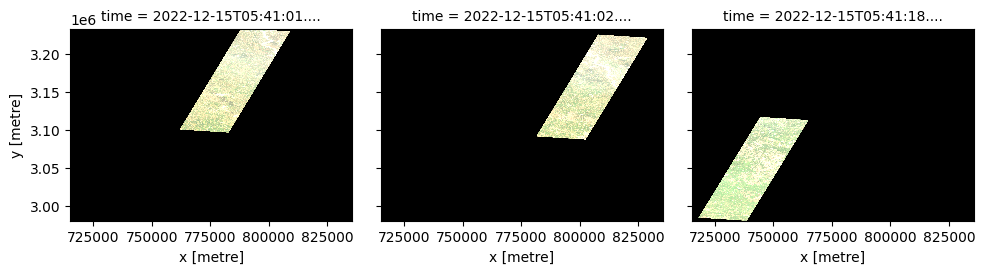

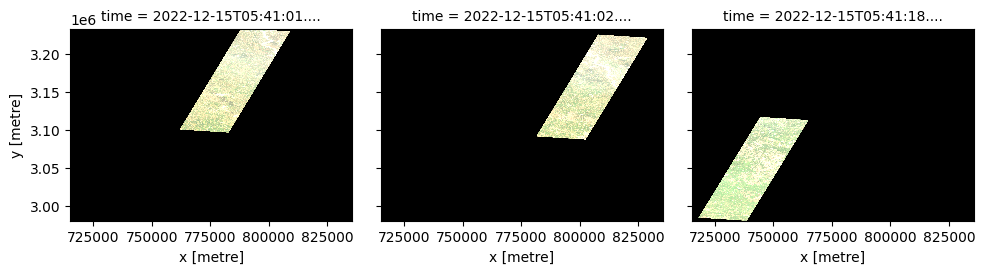

In [13]:
### RGB Time Series
if rgb_vmin is None:
    print("RGB visualization skipped: required bands not available")
else:
    rgb_plot = plot_source.plot_rgb(
        red="image_file_R",
        green="image_file_G",
        blue="image_file_B",
        vmin=rgb_vmin,
        vmax=rgb_vmax,
    )
    display(rgb_plot.fig)

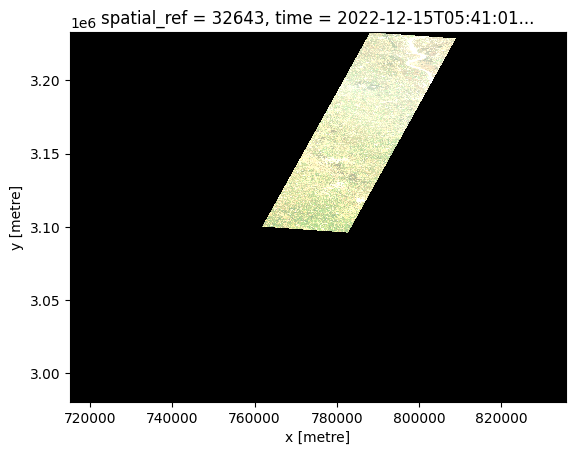

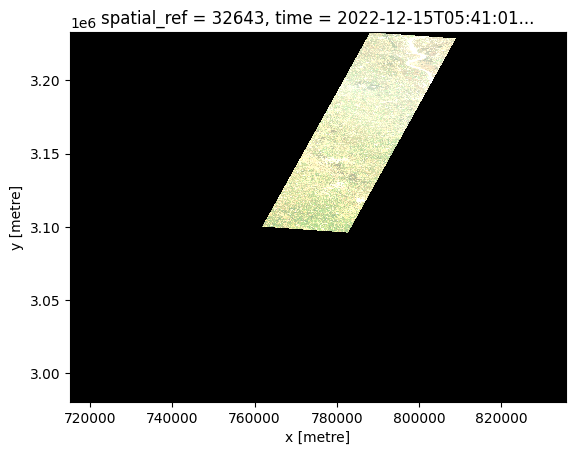

In [14]:
### True-Color Thumbnail
if rgb_vmin is None:
    print("Thumbnail skipped: RGB bands unavailable")
else:
    thumb_fig = rechunked.thumbnail(
        red="image_file_R",
        green="image_file_G",
        blue="image_file_B",
        time_index=0,
        vmin=rgb_vmin,
        vmax=rgb_vmax,
    )
    display(thumb_fig)

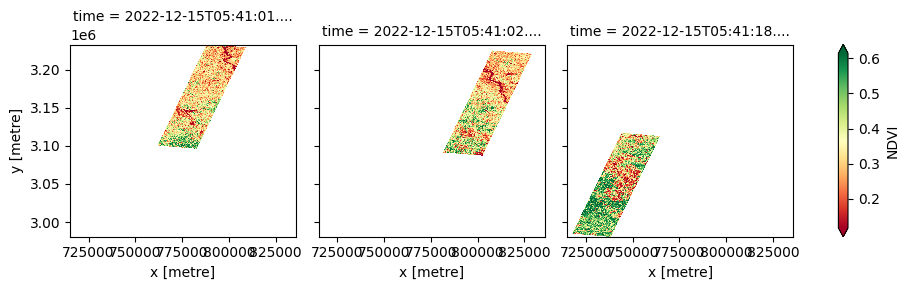

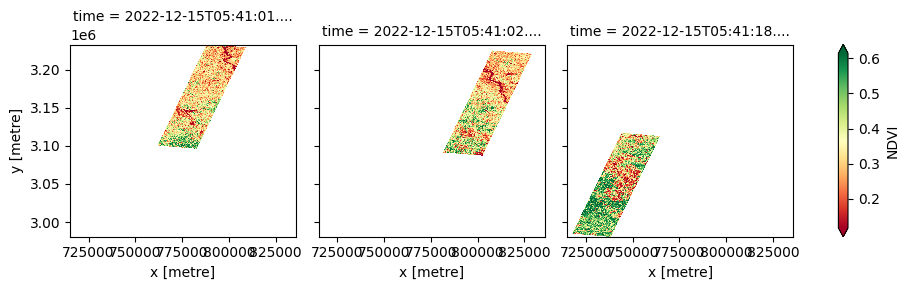

In [15]:
### NDVI Facet
if "NDVI" not in plot_source.bands:
    print("NDVI visualization unavailable")
else:
    ndvi_plot = plot_source.plot_band("NDVI", cmap="RdYlGn", robust=True)
    display(ndvi_plot.fig)

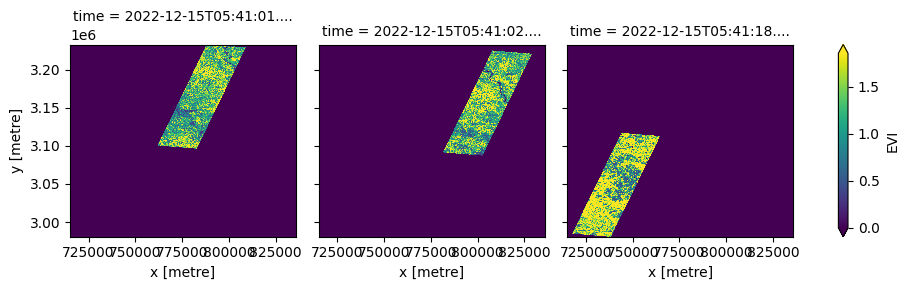

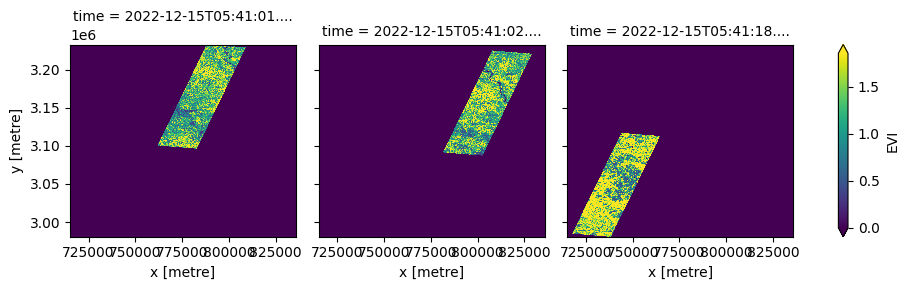

In [16]:
### EVI Facet
if "EVI" not in plot_source.bands:
    print("EVI visualization unavailable")
else:
    evi_plot = plot_source.plot_band("EVI", cmap="viridis", robust=True)
    display(evi_plot.fig)